This is my solution for **Exercise 3.1**.
To better describe my thoughts, I'd like to use this `.ipynb` to express.
Before we start, we are going to initialize some necessary elements.

In [106]:
import numpy as np
import matplotlib.pyplot as plt

Let's define a function for generating M sequence.

In [107]:
def generate_m_sequence(order, N):
    '''
    Generate an m-sequence of length N using a shift register of the specified order.
    The feedback polynomial is fixed to x^4 + x + 1.
    :param order: The order of the shift register.
    :param N: The length of the m-sequence.
    '''
    # Initialize the shift register with a non-zero state (e.g., [1, 0, 0, 0])
    register = [1] + [0] * (order - 1)
    sequence = []

    # Feedback polynomial: x^4 + x + 1
    feedback_taps = [0, 3]  # The taps correspond to x^4 and x

    # Generate the sequence of length N
    for _ in range(N):
        # Output the current state
        sequence.append(register[0])

        # Compute feedback value based on taps
        feedback = sum(register[tap] for tap in feedback_taps) % 2

        # Shift the register and insert feedback value
        register = [feedback] + register[:-1]

    return sequence

We set the M sequence to be 4 order, and repeat the sequence 10 times.

In [108]:
m_seq_order = 4 # order of the m-sequence
m_seq_np = 2**m_seq_order - 1 # period of the m-sequence
r = 50 # number of repetitions
N = r * m_seq_np # number of samples

Our system is defined as:
$$
a_1 = 1.6,
a_2 = 0.7\\
b_1 = 1.0,
b_2 = 0.4
$$
Besides, noise is applied on it. The general format is:
$$
y(k)+1.6y(k-1)+0.7y(k-2) = 1.0u(k-1)+0.4u(k-2)+V(k)\\
V(k)  = 0.9v(k)+1.2v(k-1)+0.3v(k-2)
$$

In [109]:
m_seq = generate_m_sequence(m_seq_order, N)

# generate v(k)
v = 0.2 * np.random.normal(0, 0.5, N)

# generate y(k)
y = np.zeros(N)
for i in range(2, N):
    y[i] = -1.6 * y[i-1] - 0.7 * y[i-2] + 1.0 * m_seq[i-1] + 0.4 * m_seq[i-2] + \
            0.9 * v[i]+1.2 * v[i-1]+0.3 * v[i-2]

# generate g(k) (impulse response)
# g(k) is used for validation, not for calculation.
g = np.zeros(N)
g[1] = 1.0
g[2] = -1.6 * g[1] - 0.7 * g[0] + 0.4
for i in range(3, N):
    g[i] = -1.6 * g[i-1] - 0.7 * g[i-2]

See the first 4 terms of impulse response:

In [110]:
print(g[:4]) # should be 0, 1, -1.2, 1.22

[ 0.    1.   -1.2   1.22]


Now, let's begin our travel on **system identification**.
# Maximum Likelihood
This is pretty much like Least square method, so nothing much to describe.

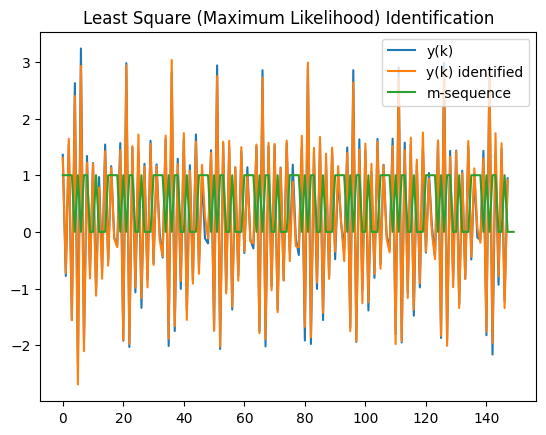

The identified model is: a1 = 1.49, a2 = 0.60, b1 = 1.02, b2 = 0.28


In [111]:
# generate the matrix
Y_ml = np.zeros((N-2, 4))
for i in range(2, N):
    Y_ml[i-2] = np.array([-y[i-1], -y[i-2], m_seq[i-1], m_seq[i-2]])

# calculate the coefficients
theta_ml = np.linalg.inv(Y_ml.T @ Y_ml) @ Y_ml.T @ y[2:]

plt.figure()
plt.plot(y[2:], label='y(k)')
plt.plot(Y_ml @ theta_ml, label='y(k) identified')
plt.plot(m_seq, label='m-sequence')
plt.legend()
plt.title('Least Square (Maximum Likelihood) Identification')
plt.show()
print('The identified model is: a1 = %.2f, a2 = %.2f, b1 = %.2f, b2 = %.2f' % (theta_ml[0], theta_ml[1], theta_ml[2], theta_ml[3]))

The system identification result is good.
# Correlation Analysis Method
Firstly, we need to calculate the impulse response $\hat g(k)$. In our simulation, the amplitude of the M sequence is 1, which means $a=1$. If $N_p$ is large, we can use the following formula ($\hat g(k)$ is the estimated impulse response)
$$
g(m)=\frac{n_p}{n_p+1}\cdot\frac 1{a^2}R_{uy}(m)\\
R_{uy}(m)=\frac1{rn_p}\sum_{k=0}^{rn_p-1}u(k-m)y(k),~m=0,1,...,n_p-1\\\rightarrow
\hat g(m)=\frac{n_p}{n_p+1}\cdot \frac1{N}\sum_{k=0}^{N-1}u(k-m)y(k)
$$
> Cause we set `N = r * m_seq_np` in the previous code, in the formula, we write $N$ instead of $rn_p$.

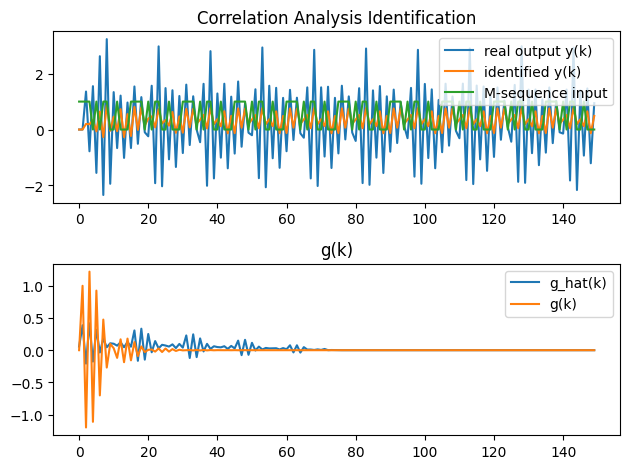

The identified model is: a1 = 0.06, a2 = -0.74, b1 = 0.39, b2 = -0.19


In [112]:
# get the impulse response g_hat(k)
u_conv = np.concatenate((np.zeros(N), m_seq))
g_hat = np.zeros(N)
for i in range(N):
    g_hat[i] = m_seq_np/(m_seq_np+1) * sum(y[j] * u_conv[N+j-i] for j in range(N-i)) / N

# calculate a1, a2, b1, b2.
HA = np.array([[g_hat[3], g_hat[2]], [g_hat[4], g_hat[3]]])
theta_a = np.linalg.inv(HA) @ np.array([-g_hat[4], -g_hat[5]])
a1, a2 = theta_a[0], theta_a[1]

HB = np.array([[1, 0], [a1, 1]])
theta_b = HB @ np.array([g_hat[1], g_hat[2]])
b1, b2 = theta_b[0], theta_b[1]
theta_cam = np.array([a1, a2, b1, b2])
    
# calculate the identified output y(k)
y_identified = np.zeros(N)
for i in range(2, N):
    y_identified[i] = -a1 * y_identified[i-1] - a2 * y_identified[i-2] + b1 * m_seq[i-1] + b2 * m_seq[i-2]

plt.figure()
plt.subplot(211)
plt.plot(y, label='real output y(k)')
plt.plot(y_identified, label='identified y(k)')
plt.plot(m_seq, label='M-sequence input')
plt.legend()
plt.title('Correlation Analysis Identification')
plt.subplot(212)
plt.plot(g_hat, label='g_hat(k)')
plt.plot(g, label='g(k)')
plt.legend()
plt.title('g(k)')
plt.tight_layout()
plt.show()
print('The identified model is: a1 = %.2f, a2 = %.2f, b1 = %.2f, b2 = %.2f' % (a1, a2, b1, b2))

You could see, this result might not be so good. We know that if we want to use this method with out accurate calculation, we're supposed to ensure the $N_p$ is large enough. However, for a 4-order M sequence, whose $N_p$ is 15, is not large enough, so the identification result is not good.

# Recursive Gradient Method
For:
$$
\phi(k)=\begin{bmatrix}-y(k-1)~-y(k-2)~u(k-1)~u(k-2)\end{bmatrix}\\
\theta=\begin{bmatrix}-a_1~~a_2~~b_1~~b_2\end{bmatrix}^T
$$
Here we're to follow:
$$
\hat\theta(k) = \hat\theta(k-1)+
\frac{\alpha\phi(k)}{c+\phi^T(k)\phi(k)}
(y(k)-\phi^T(k)\hat\theta(k-1))
$$
where $c > 0,~0<\alpha<2$.

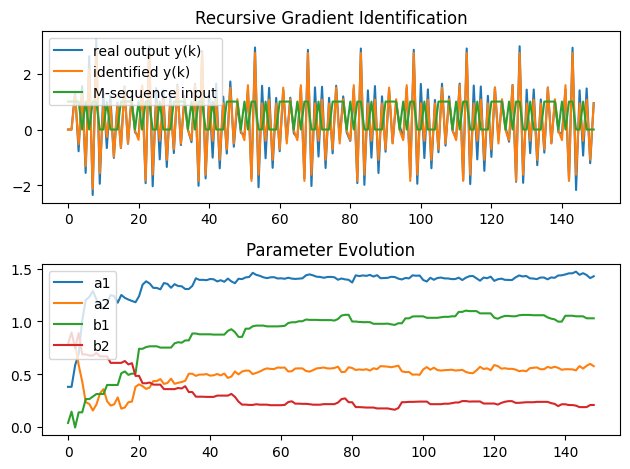

The identified model is: a1 = 1.43, a2 = 0.58, b1 = 1.03, b2 = 0.21


In [113]:
alpha = 0.5
c = 0.5
theta_rg = np.random.rand(4)
theta_rg_rec = [theta_rg]
for j in range(2, N):
    phi = np.array([-y[j-1], -y[j-2], m_seq[j-1], m_seq[j-2]]) # 1 dimensional array,so we ignore its transpose.
    theta_rg = theta_rg + alpha/(c + phi.T @ phi) * (y[j] - phi.T @ theta_rg) * phi
    theta_rg_rec.append(theta_rg)

#display the result
y_identified = np.zeros(N)
for i in range(2, N):
    y_identified[i] = -theta_rg[0] * y_identified[i-1] - theta_rg[1] * y_identified[i-2] + \
        theta_rg[2] * m_seq[i-1] + theta_rg[3] * m_seq[i-2]
plt.figure()
plt.subplot(211)
plt.plot(y, label='real output y(k)')
plt.plot(y_identified, label='identified y(k)')
plt.plot(m_seq, label='M-sequence input')
plt.legend()
plt.title('Recursive Gradient Identification')
plt.subplot(212)
plt.plot(theta_rg_rec, label=['a1', 'a2', 'b1', 'b2'])
plt.legend()
plt.title('Parameter Evolution')
plt.tight_layout()
plt.show()
print('The identified model is: a1 = %.2f, a2 = %.2f, b1 = %.2f, b2 = %.2f' % (theta_rg[0], theta_rg[1], theta_rg[2], theta_rg[3]))

The identification result is somehow good, and it looks convergent but not strongly convergent.
# Stochastic Newton method
For
$$
\phi(k)=\begin{bmatrix}-y(k-1)~-y(k-2)~u(k-1)~u(k-2)\end{bmatrix}\\
\theta=\begin{bmatrix}-a_1~~a_2~~b_1~~b_2\end{bmatrix}^T
$$

We're to follow the mathematic formula ($\hat\theta$ represents the estimated $\theta$):
$$
\hat{\theta}(k) = \hat{\theta}(k-1) + \rho(k) R^{-1}(k) \varphi(k) \left( y(k) - \varphi^T(k)\hat{\theta}(k-1) \right) \\%\tag{3.4.6}\\
R(k) = R(k-1) + \rho(k) \left( \varphi(k) \varphi^T(k) - R(k-1) \right) \\%\tag{3.4.7}\\
$$
where the initial value of $ R(k) $ can be taken as $ R(0) = I $, and$ \rho(k) $ is the convergence factor, which satisfies:
$$
\rho(k) > 0, \forall k; \quad \lim_{k \to \infty} \rho(k) = 0
\\
\sum_{k=1}^{\infty} \rho(k) = \infty; \quad \sum_{k=1}^{\infty} \rho^2(k) = \sigma^2
$$

Amazing that, for a sequence $f(k)=\frac{1}{k}$, it satisfies the requirement. So we choose $\rho(k)=\frac{1}{k}$.


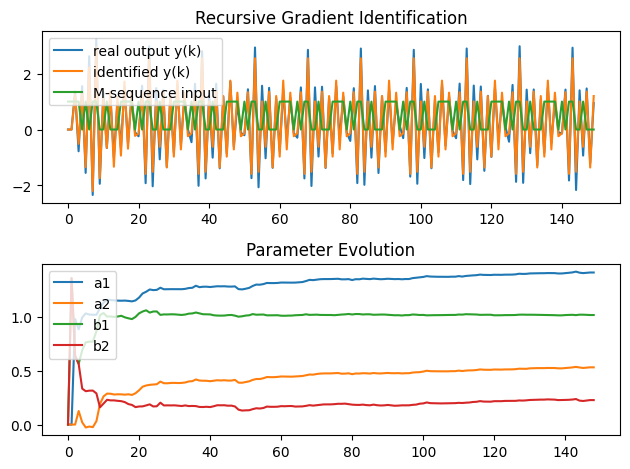

The identified model is: a1 = 1.41, a2 = 0.53, b1 = 1.02, b2 = 0.23


In [114]:
theta_sn = np.zeros((4,1))
theta_sn_rec = [theta_sn.reshape(4)]
R = np.eye(4)
for j in range(2, N):
    phi = np.array([-y[j-1], -y[j-2], m_seq[j-1], m_seq[j-2]]).reshape((4,1))
    R = R + (phi @ phi.T - R)/(j-1)
    # if the determinant of R is too small, reset R to identity matrix
    if abs(np.linalg.det(R)) < 1e-8:
        R = np.eye(4)
    theta_sn = theta_sn + np.linalg.inv(R) @ phi * (y[j] - phi.T @ theta_sn)/(j-1)
    theta_sn_rec.append(theta_sn.reshape(4))
theta_sn = theta_sn.reshape(4)

a1, a2, b1, b2 = theta_sn
# display the result
y_identified = np.zeros(N)
for i in range(2, N):
    y_identified[i] = -a1 * y_identified[i-1] - a2 * y_identified[i-2] + b1 * m_seq[i-1] + b2 * m_seq[i-2]

plt.figure()
plt.subplot(211)
plt.plot(y, label='real output y(k)')
plt.plot(y_identified, label='identified y(k)')
plt.plot(m_seq, label='M-sequence input')
plt.legend()
plt.title('Recursive Gradient Identification')
plt.subplot(212)
plt.plot(theta_sn_rec, label=['a1', 'a2', 'b1', 'b2'])
plt.legend()
plt.title('Parameter Evolution')
plt.tight_layout()
plt.show()
print('The identified model is: a1 = %.2f, a2 = %.2f, b1 = %.2f, b2 = %.2f' % (a1, a2, b1, b2))

The identification is also good, and looks strongly convergent visually.